In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
import pyodbc

C:\Users\80117059\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [1369]:
def create_connection_to_netezza(dbname="xxx", dbhost="xx.x.xx.xxx", dbport="xxxxx",
                                     dbuser="xxxxxxx",dbpass="xxxxx"):
        connection_string = "Driver={};servername={}"\
                              ";port={};database={}"\
                              ";username={};password={};".format(
                                  "{NetezzaSQL}",dbhost, dbport, 
                                  dbname, dbuser, dbpass)                           
        conn_engine = pyodbc.connect(connection_string)
        db_cursor = conn_engine.cursor()
        return (conn_engine, db_cursor)
conn, cursor = create_connection_to_netezza(dbname='PROD')

In [3]:
def join_dataframe(primary, secondaries, method, join_keys):
    merge = primary.copy()
    for dataframe in secondaries:
        merge = pd.merge(merge, dataframe, how=method, on=join_keys)
    return merge

In [578]:
def get_plant_class(number):
    if number >= 200: return 4
    elif number >= 100: return 3
    elif number >= 50: return 2
    else: return 1
    
plant_class_ref = \
    merge_dataset.groupby('plant')['unit_serial_number'].count().sort_values(ascending=False).reset_index()
plant_class_ref['plant_class'] = \
    plant_class_ref.apply(lambda x: 0 if x.get('plant')=='#N/A' else get_plant_class(x.get('unit_serial_number')), axis=1)
plant_class_ref = plant_class_ref.set_index('plant')

In [761]:
def build_feature(dataframe):
    new_df = dataframe.copy()
    # komtrax features
    for col in ['daily_actual_work_value', 'daily_smr_value', 'daily_travel_value', 'daily_emode', 'daily_pmode']:
        new_df[col] = (new_df[col]/60.0).astype(float)
    new_df['daily_productivity'] = (new_df['daily_actual_work_value']/new_df['daily_smr_value']).astype(float)
    new_df['delta_pe_mode'] = ((new_df['daily_pmode'] - new_df['daily_emode'])/new_df['daily_smr_value']).astype(float)
    new_df['fuel_consumption_ratio'] = (new_df['daily_fuel_value']/new_df['daily_smr_value']).astype(float)
    
    # industry sector encoding
    sector_list = ['CON', 'AGR', 'FOR', 'MNS', 'MNG']
    for sector in sector_list:
        new_df["is_sector_"+sector] = (new_df['industry_sector']==sector).astype(int)
        
    # plant class
    new_df['plant_class'] = new_df['plant'].apply(lambda x: int(plant_class_ref.loc[x].get('plant_class')))
    
    return new_df

In [909]:
def cluster_by_working_behavior(X, num_cluster, pca_component=None, mapminmax=False, 
                                linkage='ward', affinity='euclidean'):
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
           
    if mapminmax:
        scaler = StandardScaler()
        X[:,:7] = scaler.fit_transform(X[:,:7])
    
    if pca_component is not None:
        pca = PCA(n_components=pca_component)
        X = pca.fit_transform(X)
        print("PCA Explained Variance: ", np.sum(pca.explained_variance_ratio_))
    
    model = AgglomerativeClustering(num_cluster, connectivity=None, linkage=linkage, affinity=affinity)
    model.fit(X)
    return model.labels_

In [355]:
def cluster_by_gps_location(X):
    from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
    from sklearn.neighbors import kneighbors_graph
    knn_graph = kneighbors_graph(X, 100, include_self=False)
    model = AgglomerativeClustering(10, connectivity=knn_graph, linkage='ward', affinity='euclidean')
    model.fit(X)
    return model.labels_

In [1507]:
def assign_fuel_efficiency_labels(data, 
                                  distribution_threshold=30, 
                                  regression_threshold=50, 
                                  zcore_threshold=[-2, 1, 2]):
    n_data = len(data)
    labels = np.array(['Unassigned']*n_data)
    fuel_rate = data['fuel_consumption_ratio'].values
    excelent_thres = zcore_threshold[0]
    poor_thres = zcore_threshold[1]
    very_poor_thres = zcore_threshold[2]
    
    if n_data < distribution_threshold: # assign label based on reference
        labels[np.where(fuel_rate>=25)] = "VERY_POOR"
        labels[np.where((fuel_rate>=22) & (fuel_rate<25))] = "POOR"
        labels[np.where((fuel_rate>=6) & (fuel_rate<22))] = "GOOD"
        labels[np.where(fuel_rate<6)] = "EXCELENT"
    else: # assign label based on z-score
        z_score = (fuel_rate - np.median(fuel_rate))/np.std(fuel_rate)
        labels[np.where(z_score >= very_poor_thres)] = "VERY_POOR"
        labels[np.where((z_score >= poor_thres) & (z_score < very_poor_thres))] = "POOR"
        labels[np.where(z_score < excelent_thres)] = "EXCELENT"
        n_unassigned = len(np.where((z_score >= -2) & (z_score < 2))[0])
        if n_unassigned < regression_threshold:
            labels[np.where((z_score >= excelent_thres) & (z_score < poor_thres))] = "GOOD"
        else: # assign label based on anomaly in regression (unpredictability)
            index = np.where((z_score >= excelent_thres) & (z_score < poor_thres))
            X = data[work_behave_features].values
            y = data['fuel_consumption_ratio'].values
            regressor, mape, errors = predict_fuel_consumption_rate(X, y)
            label_from_errors = assign_label_from_errors(errors, err_thres=2*mape)
            labels[index] = label_from_errors[index]
    return labels

def predict_fuel_consumption_rate(X, y):
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.svm import SVR
    from sklearn.linear_model import Ridge
    
    def MAPE(y_true, y_pred):
        ape = np.abs(y_true-y_pred)/y_true
        mape = np.mean(ape[np.where(y_true>0)])
        return mape

#     regressor = GradientBoostingRegressor()
    regressor = Ridge()
    regressor.fit(X, y)
    y_pred = regressor.predict(X)
    errors = (y-y_pred)*1.0/y_pred
    return (regressor, MAPE(y, y_pred), errors)

def assign_label_from_errors(errors, err_thres=0.5):
    labels = []
    for i in range(len(errors)):
        if errors[i] >= err_thres:
            labels.append('POOR')
        else:
            labels.append('GOOD')
    return np.array(labels)

# Load Required Data

In [105]:
machine_identification = pd.read_csv('../Data Clean/machine_identification.csv').drop(['gps_datetime','gps_latitude', 'gps_longitude'],1)
daily_fuel = pd.read_csv('../Data Clean/daily_fuel.csv').drop(['gps_datetime','gps_latitude', 'gps_longitude'],1)
daily_actual_work = pd.read_csv('../Data Clean/daily_actual_work.csv').drop(['gps_datetime','gps_latitude', 'gps_longitude'],1)
daily_smr = pd.read_csv('../Data Clean/daily_smr.csv').drop(['gps_datetime','gps_latitude', 'gps_longitude'],1)
daily_travel = pd.read_csv('../Data Clean/daily_travel.csv').drop(['gps_datetime','gps_latitude', 'gps_longitude'],1)
daily_opmode_local = pd.read_csv('../Data Clean/daily_opmode_local.csv').drop(['gps_datetime','gps_latitude', 'gps_longitude'],1)
machine_gps = pd.read_csv('../Data Clean/machine_gps.csv')
# machine_gps['local_date'] = machine_gps['gps_datetime'].map(lambda x: str(x)[0:10])

# Load Unit Sector Dataset

In [36]:
sql = """
    select modl_num unit_model, SRL_NUM unit_serial_number, INDUS industry_sector, PLNT plant, NAME_1 customer 
    FROM(
        select distinct modl_num, SRL_NUM, INDUS, PLNT, NAME_1, 
        ROW_NUMBER()OVER(PARTITION BY SRL_NUM, modl_num ORDER BY CHG_ON DESC, PPN_DTTM DESC) AS RANK, 
        PPN_DTTM, CHG_ON
        from sor.sap_unit_populasi BOO
        where modl_num LIKE '%PC200-8%' and length(INDUS)>2 and modl_num NOT LIKE '%U%'
    ) FOO
    WHERE RANK=1
    order by srl_num
"""
unit_sector = pd.read_sql(
    sql, 
    conn)
unit_sector.columns = [str(c).lower() for c in unit_sector.columns]
unit_sector.head()

,unit_model,unit_serial_number,industry_sector,plant,customer
0,PC200-8,300029,CON,PLB,LIBRATA UTAMA
1,PC200-8,300030,AGR,JBI,FORESTINDO PERMAI
2,PC200-8,305161,CON,PLB,HARUM NUSANTARA MAKMUR
3,PC200-8,315785,CON,UPG,WIJAYA PRATAMA SUKSES GEMILANG
4,PC200-8,315786,CON,UPG,Ir. AFRY HIRAY


# Join All Dataset

In [1258]:
secondary_dataset_list = [daily_actual_work, daily_smr, daily_travel, daily_opmode_local]
merge_dataset = join_dataframe(primary=daily_fuel,
                               secondaries=secondary_dataset_list, 
                               method='inner', 
                               join_keys=['manufacturer', 'unit_model', 'model_type', 'unit_serial_number', 'local_date']
                              ).drop(['daily_smr_map', 'daily_lmode', 'daily_llmode','daily_lmmode', 
                                      'daily_lhmode','daily_mlmode','daily_mmmode','daily_mhmode',
                                      'daily_hlmode','daily_hmhmode', 'daily_bmode'],1)
merge_dataset = pd.merge(merge_dataset, machine_gps, how='inner', on=['unit_model', 'model_type','unit_serial_number','manufacturer'])
merge_dataset['unit_model'] = merge_dataset['unit_model'] + '-' + merge_dataset['model_type']
merge_dataset = merge_dataset.drop('model_type',1)
merge_dataset = pd.merge(merge_dataset, unit_sector, how='left', on=['unit_model', 'unit_serial_number']).fillna('#N/A')

# filter only unit in indonesia geofence
merge_dataset = merge_dataset[(merge_dataset['gps_latitude']>=-12) & (merge_dataset['gps_latitude']<=7) &
              (merge_dataset['gps_longitude']>=90) & (merge_dataset['gps_longitude']<=145)]

# cluster by area location
merge_dataset['location_cluster'] = cluster_by_gps_location(merge_dataset[['gps_latitude', 'gps_longitude']].values)

# Select PC200-8 Only

In [1291]:
select_dataset = merge_dataset[
    (merge_dataset['unit_model']=='PC200-8M0') & 
    (merge_dataset['daily_actual_work_value']>120) & 
    (merge_dataset['daily_smr_value']>120)].copy()
len(select_dataset)

2759

In [1292]:
work_behave_features = [
    'daily_smr_value', 'daily_actual_work_value', 'daily_travel_value', 'daily_pmode',
    'delta_pe_mode','daily_productivity', 'daily_emode',
    'gps_latitude', 'gps_longitude',
    "is_sector_CON", "is_sector_AGR", "is_sector_FOR", "is_sector_MNS", "is_sector_MNG", "plant_class"]

In [1508]:
featured_dataset = build_feature(select_dataset) 
featured_dataset['fuel_efficiency_label'] = 'None'
list_location_cluster = featured_dataset['location_cluster'].drop_duplicates().tolist()
for location in list_location_cluster:
    location_df = featured_dataset[(featured_dataset['location_cluster']==location)].copy()
    
    # cluster by working behavior
    X = location_df[work_behave_features].values
    num_cluster = np.min([int(len(X)/50),5])
    labels = cluster_by_working_behavior(X, num_cluster=num_cluster, pca_component=None, mapminmax=False)
    location_df['working_behavior_cluster'] = labels
    list_working_cluster = location_df['working_behavior_cluster'].drop_duplicates().tolist()
    
    # asign fuel efficiency label for each working behavior cluster
    for cluster in list_working_cluster:
        working_cluster = location_df[location_df['working_behavior_cluster']==cluster].copy()
        labels = assign_fuel_efficiency_labels(working_cluster)
        location_df.loc[working_cluster.index, 'fuel_efficiency_label'] = labels
        
    featured_dataset.loc[location_df.index, 'working_behavior_cluster'] = location_df['working_behavior_cluster']
    featured_dataset.loc[location_df.index, 'fuel_efficiency_label'] = location_df['fuel_efficiency_label']

In [1510]:
featured_dataset.to_excel('fuel_consumption_index_PC200-8M0(2).xlsx', index=False)

In [1469]:
featured_dataset.columns

Index(['manufacturer', 'unit_model', 'unit_serial_number', 'local_date',
       'daily_fuel_value', 'daily_actual_work_value', 'daily_smr_value',
       'daily_travel_value', 'daily_emode', 'daily_pmode', 'gps_datetime',
       'gps_origin', 'gps_datum', 'gps_latitude', 'gps_longitude',
       'industry_sector', 'plant', 'customer', 'location_cluster',
       'daily_productivity', 'delta_pe_mode', 'fuel_consumption_ratio',
       'is_sector_CON', 'is_sector_AGR', 'is_sector_FOR', 'is_sector_MNS',
       'is_sector_MNG', 'plant_class', 'fuel_efficiency_label',
       'working_behavior_cluster'],
      dtype='object')

# -------- Fuel Label Assignment Ends Here -----------

# Peek The Data

In [1470]:
featured_dataset[featured_dataset['fuel_efficiency_label']=='VERY_POOR'].sort_values('fuel_consumption_ratio', ascending=False)

,manufacturer,unit_model,unit_serial_number,local_date,daily_fuel_value,daily_actual_work_value,daily_smr_value,daily_travel_value,daily_emode,daily_pmode,...,delta_pe_mode,fuel_consumption_ratio,is_sector_CON,is_sector_AGR,is_sector_FOR,is_sector_MNS,is_sector_MNG,plant_class,fuel_efficiency_label,working_behavior_cluster
2470,KOMATSU,PC200-8M0,C21544,2019-01-09,180.0,7.550000,7.700000,1.183333,0.100000,7.450000,...,0.954545,23.376623,1,0,0,0,0,4,VERY_POOR,3.0
4309,KOMATSU,PC200-8M0,C14650,2019-01-09,177.1,7.416667,7.716667,2.366667,0.316667,7.116667,...,0.881210,22.950324,1,0,0,0,0,3,VERY_POOR,4.0
2727,KOMATSU,PC200-8M0,C20854,2019-01-09,201.2,8.466667,8.833333,2.183333,0.016667,8.450000,...,0.954717,22.777358,1,0,0,0,0,3,VERY_POOR,4.0
2346,KOMATSU,PC200-8M0,C21808,2019-01-09,197.3,8.100000,9.083333,2.133333,0.000000,8.116667,...,0.893578,21.721101,1,0,0,0,0,3,VERY_POOR,0.0
2915,KOMATSU,PC200-8M0,C20544,2019-01-09,384.7,17.333333,18.233333,1.133333,0.000000,17.366667,...,0.952468,21.098720,1,0,0,0,0,4,VERY_POOR,2.0
2424,KOMATSU,PC200-8M0,C21661,2019-01-09,61.3,2.733333,2.916667,0.666667,0.250000,2.500000,...,0.771429,21.017143,0,1,0,0,0,2,VERY_POOR,3.0
4521,KOMATSU,PC200-8M0,C14076,2019-01-09,95.3,4.316667,4.566667,0.950000,4.333333,0.000000,...,-0.948905,20.868613,0,1,0,0,0,1,VERY_POOR,3.0
4261,KOMATSU,PC200-8M0,C14779,2019-01-09,94.5,4.116667,4.566667,1.583333,1.566667,2.550000,...,0.215328,20.693431,0,0,1,0,0,3,VERY_POOR,3.0
3006,KOMATSU,PC200-8M0,C20275,2019-01-09,278.8,12.216667,13.500000,1.700000,0.000000,0.000000,...,0.000000,20.651852,1,0,0,0,0,4,VERY_POOR,0.0
4323,KOMATSU,PC200-8M0,C14621,2019-01-09,125.5,5.833333,6.100000,0.516667,0.000000,5.833333,...,0.956284,20.573770,1,0,0,0,0,4,VERY_POOR,1.0


In [1471]:
featured_dataset.groupby(['location_cluster','working_behavior_cluster'])['unit_serial_number'].count()#*100/len(select_dataset)

location_cluster  working_behavior_cluster
0                 0.0                         180
                  1.0                          79
                  2.0                          34
                  3.0                         127
                  4.0                          20
1                 0.0                         101
                  1.0                           5
                  2.0                          63
2                 0.0                          78
                  1.0                          73
                  2.0                          47
3                 0.0                          24
                  1.0                          81
                  2.0                          26
                  3.0                         137
                  4.0                          39
4                 0.0                         125
                  1.0                          47
                  2.0                          12
5      

In [1500]:
featured_dataset.groupby(['fuel_efficiency_label'])['fuel_consumption_ratio'].agg(['mean', 'count'])

,mean,count
fuel_efficiency_label,,
EXCELENT,0.418104,106
GOOD,0.775632,2495
POOR,0.817025,140
VERY_POOR,0.934736,18


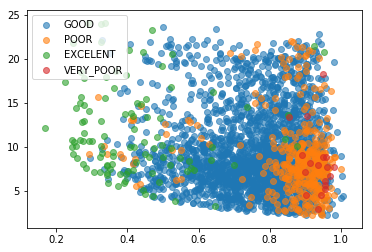

In [1516]:
for label in featured_dataset['fuel_efficiency_label'].drop_duplicates():
    subset = featured_dataset[featured_dataset['fuel_efficiency_label']==label]
    plt.scatter(subset['daily_productivity'], 
                subset['daily_smr_value'], label=label, alpha=0.6)
plt.legend()

# Compare Sample with Communities

In [1515]:
label_comparison = 'VERY_POOR'
compared_with = 'GOOD'

anomaly_sample = featured_dataset[featured_dataset['fuel_efficiency_label']==label_comparison].reset_index(drop=True).loc[0]
location = anomaly_sample.get('location_cluster')
working_behaviour = anomaly_sample.get('working_behavior_cluster')
communities = featured_dataset[(featured_dataset['location_cluster']==location) & 
                               (featured_dataset['working_behavior_cluster']==working_behaviour) & 
                               (featured_dataset['fuel_efficiency_label']==compared_with)].reset_index(drop=True)
distance_measure_features = ['daily_smr_value', 'daily_actual_work_value', 'daily_travel_value', 'daily_pmode', 'daily_emode']
distance = np.ones(len(communities))*1000
for i in range(len(communities)):
    x1 = anomaly_sample.get(distance_measure_features).values
    x2 = communities.loc[i].get(distance_measure_features).values
    distance[i] = np.sqrt(np.sum((x1-x2)**2))
communities['distance'] = distance
communities = communities.sort_values('distance').reset_index(drop=True)


community_index = 0
compare = pd.merge(anomaly_sample.reset_index(), communities.loc[community_index].reset_index(), how='inner', on='index')
compare.columns = ['parameter', label_comparison, compared_with]
print("Behaviour Similarity: ", communities.loc[community_index].get('distance'))
compare

Behaviour Similarity:  0.8244526804021088


,parameter,VERY_POOR,GOOD
0,manufacturer,KOMATSU,KOMATSU
1,unit_model,PC200-8M0,PC200-8M0
2,unit_serial_number,J60581,J60665
3,local_date,2019-01-09,2019-01-09
4,daily_fuel_value,152.6,120.6
5,daily_actual_work_value,7.43333,6.88333
6,daily_smr_value,7.93333,8.08333
7,daily_travel_value,1.08333,0.9
8,daily_emode,7.45,6.88333
9,daily_pmode,0,0


# Visualization and Analysis

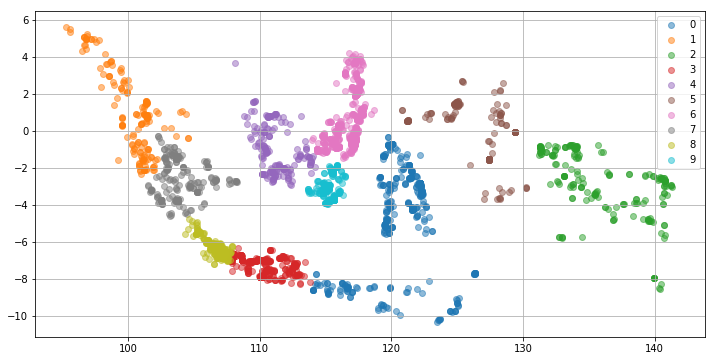

,location_cluster,unit_serial_number
0,0,440
1,1,169
2,2,198
3,3,307
4,4,184
5,5,148
6,6,597
7,7,222
8,8,264
9,9,230


In [1268]:
labels = select_dataset['location_cluster'].values
X = select_dataset[['gps_longitude','gps_latitude']].values
plt.figure(figsize=(12,6))
for label in set(labels):
    if label >= 10: marker = 'x' 
    else: marker = 'o'
    xplot = X[np.where(labels==label)]
    plt.scatter(xplot[:,0],xplot[:,1],label=label, marker=marker, alpha=0.5)
plt.grid(), plt.legend(), 
plt.show()
select_dataset.groupby('location_cluster')['unit_serial_number'].count().reset_index()

# Sample One Clusters

In [1269]:
cluster_location_df = build_feature(
    select_dataset[(select_dataset['location_cluster']==8) & (select_dataset['daily_smr_value']>=120)]
)
print(len(cluster_location_df))

264


# Clustering by Wroking Behavior

In [1270]:
X = cluster_location_df[work_behave_features].values
num_cluster = np.min([int(len(X)/50),5])
labels = cluster_by_working_behavior(X, num_cluster=num_cluster, pca_component=None, mapminmax=False)
cluster_location_df['working_behavior_cluster'] = labels

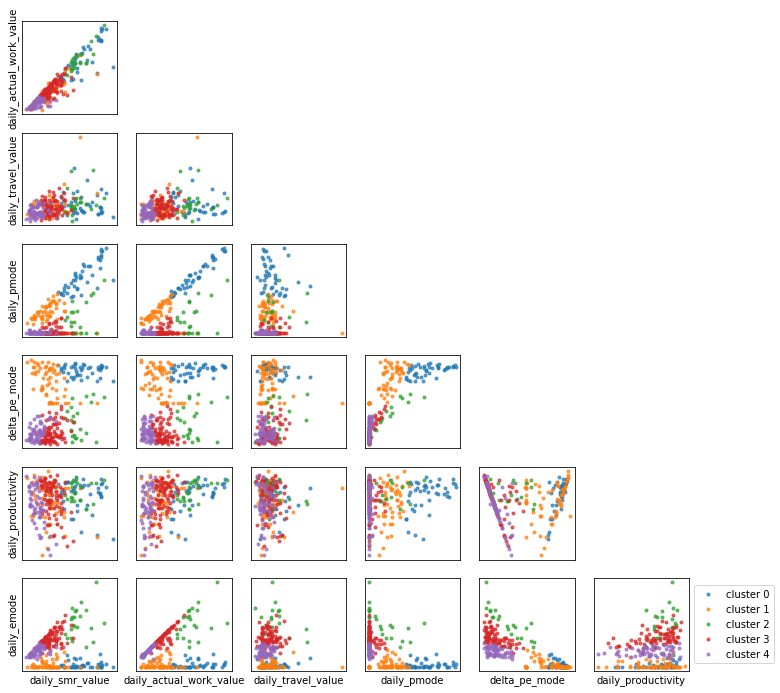

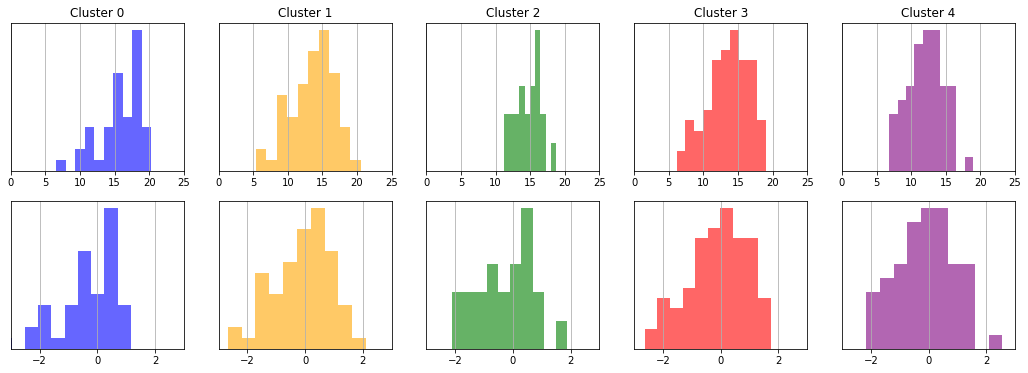

In [1271]:
n_features = 7
fig, axes = plt.subplots(nrows=n_features, ncols=n_features, figsize=(14,14))
for i in range(n_features):
    for j in range(i,n_features):
        ax = axes[j,i]
        ax2 = axes[i,j]
        ax2.remove()
        x = cluster_location_df[work_behave_features[i]].values
        y = cluster_location_df[work_behave_features[j]].values
        for label in set(labels):
            alpha = 0.7 if label>-1 else 0.1
            ax.plot(x[np.where(labels==label)],y[np.where(labels==label)],'.', 
                    label='cluster {}'.format(label), alpha=alpha)
        ax.get_xaxis().set_ticks([]), ax.get_yaxis().set_ticks([])
        if i == 0: ax.set_ylabel(work_behave_features[j])
        if j == n_features-1: ax.set_xlabel(work_behave_features[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18,6))
cluster_color = ['blue', 'orange', 'green', 'red', 'purple']
for i in range(2):
    for cluster in range(len(set(labels))):
        data = cluster_location_df[cluster_location_df['working_behavior_cluster']==cluster]['fuel_consumption_ratio'].values
        ax = axes[i,cluster]
        if i==1:
            data = (data - np.median(data))/np.std(data)
            xlim = [-3,3]
            title = ""
        else:
            xlim = [0,25]
            title = "Cluster {}".format(cluster)
        ax.hist(data, density=True, color=cluster_color[cluster], alpha=0.6)
        ax.set_xlim(xlim)
        ax.get_yaxis().set_ticks([])
        ax.grid(), ax.set_title(title)
plt.show()

In [1218]:
cluster_location_df.groupby(['working_behavior_cluster'])['unit_serial_number'].count()

working_behavior_cluster
0    43
1    61
2    22
3    81
4    62
Name: unit_serial_number, dtype: int64

# Anomaly Labeling
1. Step 1: If cluster size < 30, mark all with fuel rate > 25 as "VERY POOR", fuel_rate > 21 as "POOR", else "GOOD"
2. Step 2: If cluster >= 30 make fuel consumption rate distribution
3. Step 3: From the distribution if z >= 2 mark as "VERY POOR", if z >= 1.5 mark as "POOR", if z < -2 mark as "EXCELENT", else next
4. Step 4: The rest, if size < 80, mark all as "GOOD" else, make regression and compute error
5. Step 5: If deviation >= 2 x error mark as "POOR" if deviation >= 3 x error mark as "VERY POOR"

In [1190]:
model, mae, errors = predict_fuel_consumption_rate(
    X = cluster_location_df[work_behave_features].values,
    y = cluster_location_df['fuel_consumption_ratio'].values
)
mae*100

5.112375406540507

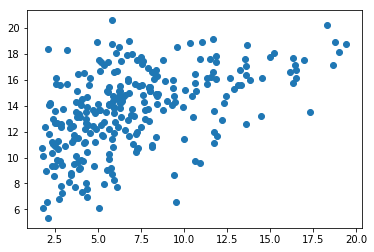

In [1028]:
X = cluster_location_df['daily_actual_work_value'].values,
y = cluster_location_df['fuel_consumption_ratio'].values
plt.scatter(X, y)

In [1022]:
pd.DataFrame({
    "features": work_behave_features,
    "importances": model.feature_importances_
}).sort_values('importances', ascending=False).reset_index(drop=True)

,features,importances
0,daily_productivity,0.220291
1,gps_latitude,0.201530
2,delta_pe_mode,0.106932
3,daily_smr_value,0.103360
4,gps_longitude,0.093356
5,daily_actual_work_value,0.088788
6,daily_travel_value,0.083293
7,daily_pmode,0.049319
8,daily_emode,0.034730
9,is_sector_CON,0.005078
